<a href="https://colab.research.google.com/github/Lupama2/IntroPython/blob/main/ICNPG_ejemplocugraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Tue May 16 20:03:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#@title Instalación de RapidsAI
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py


Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 390, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 390 (delta 89), reused 51 (delta 51), pack-reused 269
Receiving objects: 100% (390/390), 107.11 KiB | 17.85 MiB/s, done.
Resolving deltas: 100% (191/191), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.4 MB/s eta 0:00:00
***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla T4!
We will now install RAPIDS cuDF, cuML, and cuGraph via pip! 
Please stand by, should be quick...
***********************************************************************

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 496

In [ ]:
#@title Este nos viene bien para visualizar grafos
!pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# CUGRAPH

Este es un ejemplito de como leer un csv con los edges de un grafo, visualizarlo, y realizar operaciones en la gpu.

## Visualización del grafo y de la matriz de adyacencia

matriz de adjacencia:
 [[1. 1. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 1. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]
matriz de adjacencia a la 3:
 [[7. 6. 3. 3. 6. 1. 0. 0. 0.]
 [6. 3. 5. 1. 7. 2. 0. 0. 0.]
 [3. 5. 0. 5. 1. 0. 0. 0. 0.]
 [3. 1. 5. 0. 6. 3. 0. 0. 0.]
 [6. 7. 1. 6. 3. 0. 0. 0. 0.]
 [1. 2. 0. 3. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]
no zeros de la matriz:  18
no zeros de la matriz^3:  32
traza(G^3) =  14.0


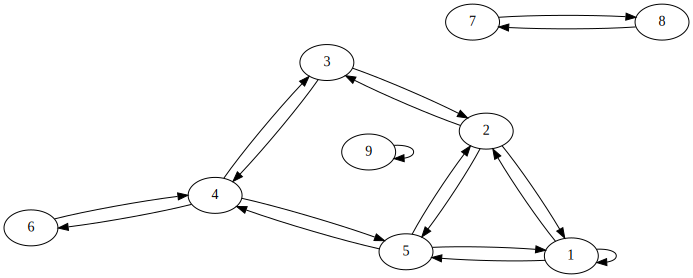

In [ ]:
#########################################
# Echemosle un vistazo al grafo usando graphiz

import cugraph
import cudf
import cupy as cp
from graphviz import Digraph

# read data into a cuDF DataFrame using read_csv
#gdf = cudf.read_csv("graph_data.csv", names=["src", "dst"], dtype=["int32", "int32"])
gdf = cudf.read_csv("https://raw.githubusercontent.com/droyktton/data/main/graph_data.csv")
dot = Digraph(comment='ICNPG2023',engine='sfdp')

gpa=gdf.to_pandas()

madj=cp.zeros((9,9))

for a, b in gpa.itertuples(index=False):
    dot.edge(str(a),str(b), constraint='false')
    madj[a-1,b-1]=1
    #print(a, b)


print("matriz de adjacencia:\n",madj)

madj3=cp.linalg.matrix_power(madj,3)
print("matriz de adjacencia a la 3:\n",madj3)

print("no zeros de la matriz: ",cp.flatnonzero(madj).size)
print("no zeros de la matriz^3: ",cp.flatnonzero(madj3).size)

print("traza(G^3) = ", cp.trace(madj3))

dot

##  CUGRAPH para obtener propiedades del grafo

In [ ]:
import cugraph
import cudf

# read data into a cuDF DataFrame using read_csv
#gdf = cudf.read_csv("graph_data.csv", names=["src", "dst"], dtype=["int32", "int32"])
gdf = cudf.read_csv("https://raw.githubusercontent.com/droyktton/data/main/graph_data.csv")

# pesos (necesarios para algunas cosas nomas)
gdf["data"] = 1.0


# We now have data as edge pairs
# create a Graph using the source (src) and destination (dst) vertex pairs
G = cugraph.Graph()
G.from_cudf_edgelist(gdf, source='src', destination='dst')

print("\n\n")



######################################
#https://es.wikipedia.org/wiki/PageRank
#
# PR(A) = (1-d)+d Sum_{i=1}^n PR(i)/C(i)
#
# A es el PageRank de la página A.
# d es un factor de amortiguación que tiene un valor entre 0 y 1.
# PR(i)son los valores de PageRank que tienen cada una de las páginas i que enlazan a A.
# C(i) es el número total de enlaces salientes de la página i (sean o no hacia A).

# Let's now get the PageRank score of each vertex by calling cugraph.pagerank
df_page = cugraph.pagerank(G)

# Let's look at the PageRank Score (only do this on small graphs)
for i in range(len(df_page)):
	print("vertex " + str(df_page['vertex'].iloc[i]) +
		" PageRank is " + str(df_page['pagerank'].iloc[i]))

print("\n\n")

#####################################
#https://en.wikipedia.org/wiki/Component_(graph_theory)

# Call cugraph.weakly_connected_components on the dataframe
df_cc = cugraph.weakly_connected_components(G)

# Use groupby on the 'labels' column of the WCC output to get the counts of each connected component label
label_gby = df_cc.groupby('labels')
label_count = label_gby.count()

print("Total number of components found : ", len(label_count))

# Call nlargest on the groupby result to get the row where the component count is the largest
largest_component = label_count.nlargest(n = 1, columns = 'vertex')
print("Size of the largest component is found to be : ", largest_component['vertex'].iloc[0])

smallest_component = label_count.nsmallest(n = 1, columns = 'vertex')
print("Size of the smallest component is found to be : ", smallest_component['vertex'].iloc[0])

#df_cc.head(20)

print("\n\n")

#############################################################
# https://en.wikipedia.org/wiki/Shortest_path_problem
# Call cugraph.sssp to get the distances from vertex 1:

df_ssp = cugraph.sssp(G, 1)

print("no todos los caminos conducen al nodo 1, y estos son los minimos:")

# Print the paths
for index, row in df_ssp.to_pandas().iterrows():
    v = int(row['vertex'])
    p = cugraph.utils.get_traversed_path_list(df_ssp, v)
    print(v, ': ', p)

print("\n\n")





vertex 1 PageRank is 0.12384827
vertex 2 PageRank is 0.12706584
vertex 4 PageRank is 0.13981377
vertex 5 PageRank is 0.12737396
vertex 3 PageRank is 0.09228361
vertex 6 PageRank is 0.05628124
vertex 7 PageRank is 0.11111111
vertex 8 PageRank is 0.11111111
vertex 9 PageRank is 0.11111111



Total number of components found :  3
Size of the largest component is found to be :  6
Size of the smallest component is found to be :  1



no todos los caminos conducen al nodo 1, y estos son los minimos:
1 :  [1]
2 :  [2, 1]
4 :  [4, 5, 1]
5 :  [5, 1]
3 :  [3, 2, 1]
6 :  [6, 4, 5, 1]
7 :  [7]
8 :  [8]
9 :  [9]





/usr/local/lib/python3.10/dist-packages/cugraph/link_analysis/pagerank.py:200: UserWarning: Pagerank expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)


## CUDF como pandas, pero en GPU

In [ ]:
import cudf
import io, requests

# download CSV file from GitHub
url="https://github.com/plotly/datasets/raw/master/tips.csv"
content = requests.get(url).content.decode('utf-8')

# read CSV from memory
tips_df = cudf.read_csv(io.StringIO(content))
tips_df['tip_percentage'] = tips_df['tip']/tips_df['total_bill']*100

# display average tip by dining party size
print(tips_df.groupby('size').tip_percentage.mean())

size
6    15.622920
1    21.729202
4    14.594901
3    15.215685
2    16.571919
5    14.149549
Name: tip_percentage, dtype: float64
